In [1]:
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Select the training configuration

In [3]:
# ================== HYPER-PARAMETERS ==================
# config: nr_classes, labels, class_weights, basemodel, image_dimension, results_and_checkpoints_folder, data_folder
i = 0
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(i)]
old_stdout = sys.stdout
log_file = open(config['results_and_checkpoints_folder'] + '/log_eval.txt', 'w')
sys.stdout = log_file

In [4]:
config

{'nr_classes': 20,
 'number_trainable_layers': 0,
 'class_weights': False,
 'augment': False,
 'basemodel': 'EfficientNetB2',
 'image_dimension': 64,
 'results_and_checkpoints_folder': 'thesis_experiments/0_0layers_algo_20classes_EfficientNetB2',
 'data_folder': 'data/split_dataframes_heuristic_labels_20221006'}

Load test set

In [5]:
# Load test set
test = hf.get_flow(df_file=config['data_folder'] + '/test_df.json.bz2',
                   nr_classes=config['nr_classes'],
                   image_dimension=config['image_dimension'])

val_threshold = hf.get_flow(df_file=config['data_folder'] + '/val_threshold_df.json.bz2',
                            nr_classes=config['nr_classes'],
                            image_dimension=config['image_dimension'])

# Create model
model = hf.create_model(n_labels=config['nr_classes'], image_dimension=config['image_dimension'], model_name=config['basemodel'], number_trainable_layers=config['number_trainable_layers'])
latest = tf.train.latest_checkpoint(config['results_and_checkpoints_folder'] + '/checkpoints')
print(latest)
model.load_weights(latest)


# Predict on validation set
print('Predicting on validation set:\n')
probs_val = model.predict(val_threshold, verbose=2)
y_true_val = hf.get_y_true(shape=probs_val.shape, classes=val_threshold.classes)

# Predict on test set
print('Predicting on test set:\n')
probs_test = model.predict(test, verbose=2)
y_true_test = hf.get_y_true(shape=(test.samples, len(test.class_indices)), 
                            classes=test.classes)

/home/matvieir/wiki_image_classification/src/classification/help_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])
/home/matvieir/wiki_image_classification/src/classification/help_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


In [51]:
def undersample(y_true, class_names, df):
    """ 
    Constructs a more balanced test set in a dummy way by adding to it only the images that contain 
    the - for the moment - most uncommon class.
    Inputs:
        - classes: [[]]
        - class_names: list with all labels: 
        - test_df: dataframe with rows containing image files and labels
    """
    # sorted_indices = np.argsort(np.sum(y_true, axis=0))
    # sorted_class_names = np.array(list(class_names))[sorted_indices]
    # least_common_class = sorted_class_names[0]
    # balanced_classes = []
    # row_ids = []
    # counter = 0 
    # for index, row in df.iterrows():
    #     counter += 1
    #     print(counter)
    #     if counter % 10 == 0:
    #         # y_true = hf.get_y_true(balanced_classes, 40)
    #         sorted_indices = np.argsort(np.sum(y_true, axis=0))
    #         sorted_class_names = np.array(class_names)[sorted_indices]
    #         least_common_class = sorted_class_names[0]
    #     if least_common_class in row.labels:
    #         balanced_classes.append(row.labels)
    #         print(balanced_classes)
    #         row_ids.append(index)

    # Randomly eliminate samples of the most common class up until 90%, 70% and 50% of the dataset

    # Calculate most common class
    y_true

    return df.loc[row_ids, :]


1
2
3
4
5
6
7
8
9
10


IndexError: too many indices for array

In [76]:
y_true = hf.get_y_true(shape=(test.samples, len(test.class_indices)), classes=test.classes)
most_common_label_idx = np.argsort(y_true.sum(axis=0))[-1]
np.array([most_common_label_idx in item for item in test.classes])


array([1, 0, 0, ..., 1, 0, 1])

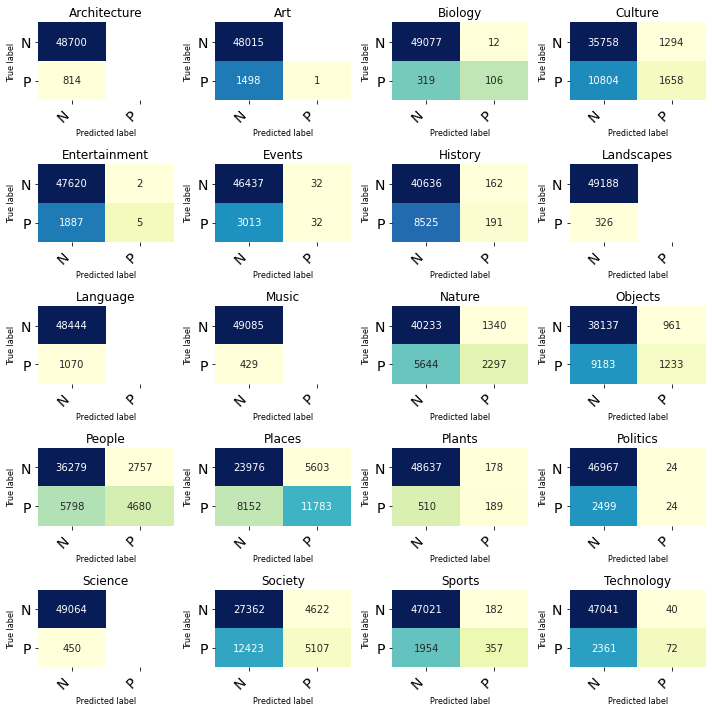

In [15]:
# ============== CONFUSION MATRICES ===================
from sklearn.metrics import multilabel_confusion_matrix

confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)
hf.plot_confusion_matrices(confusion_matrix, list(test.class_indices.keys()), config['results_and_checkpoints_folder'])

                                                     
# ======================================================

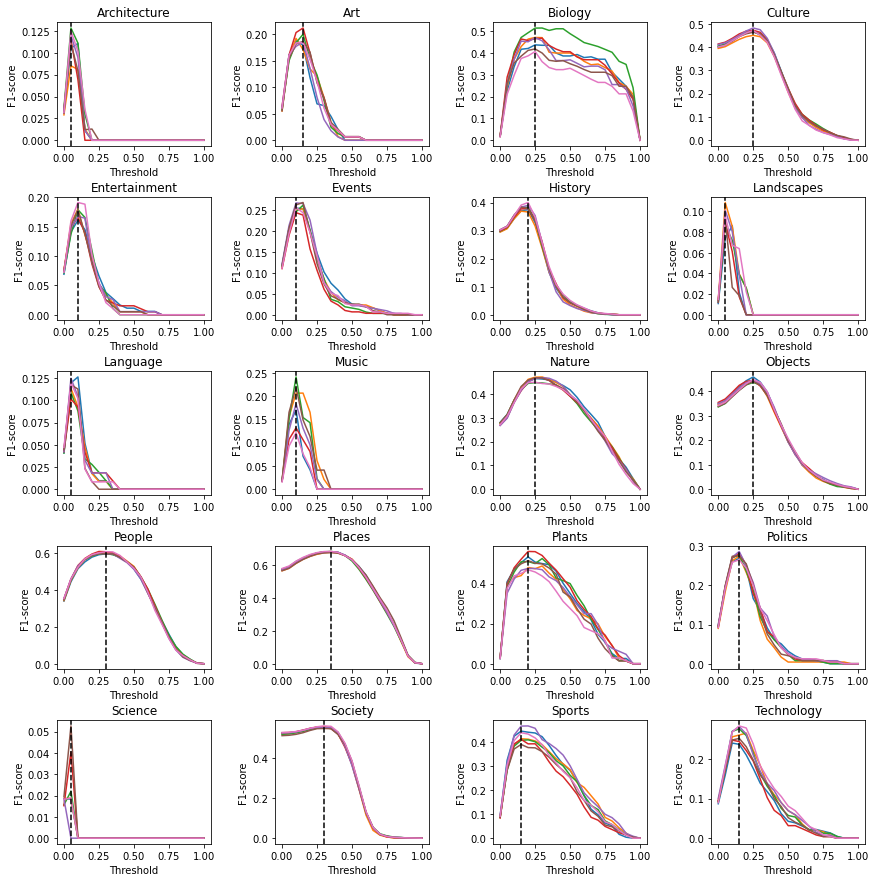

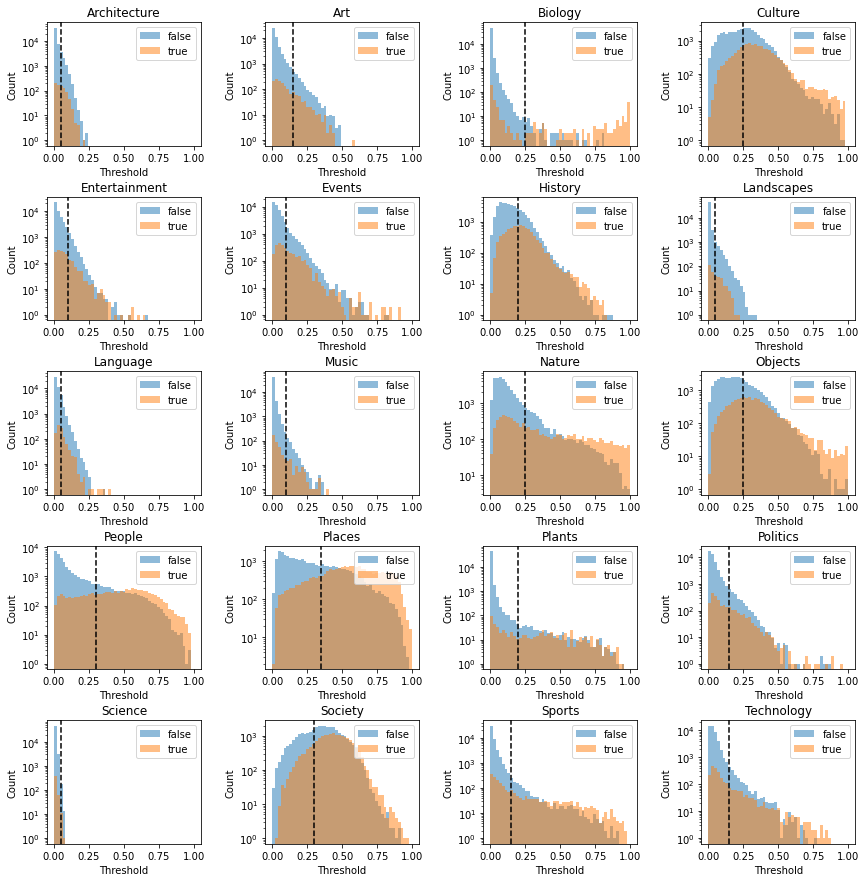

In [9]:
optim_thresholds = hf.get_optimal_threshold(y_true=y_true_val, 
                                            probs=probs_val, 
                                            thresholds=np.linspace(start=0, stop=1, num=21), 
                                            labels=list(val_threshold.class_indices.keys()), 
                                            N=7)

array([[False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [ True, False, False, ...,  True, False, False],
       [False,  True, False, ...,  True, False, False],
       [ True, False, False, ...,  True, False, False]])

In [12]:
y_pred_test_05 = 1 * (probs_test > 0.5)
y_pred_test_per_class_threshold = 1 * (probs_test > optim_thresholds)

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


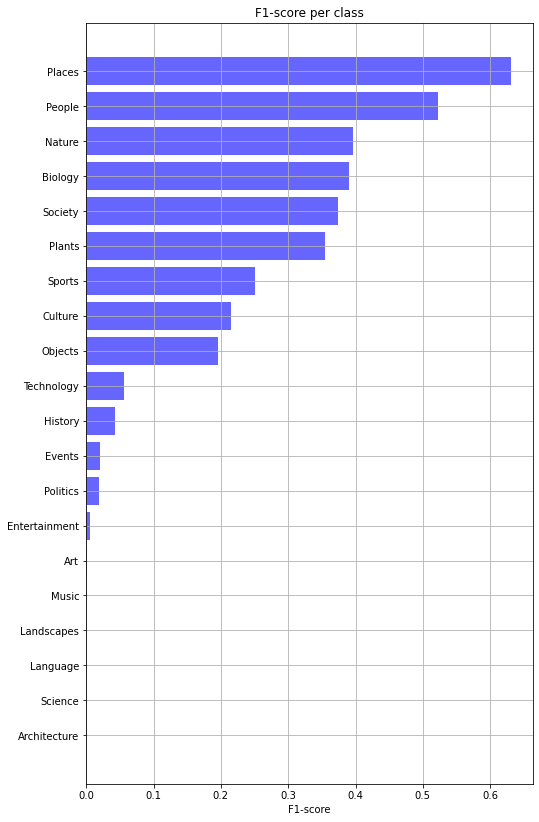

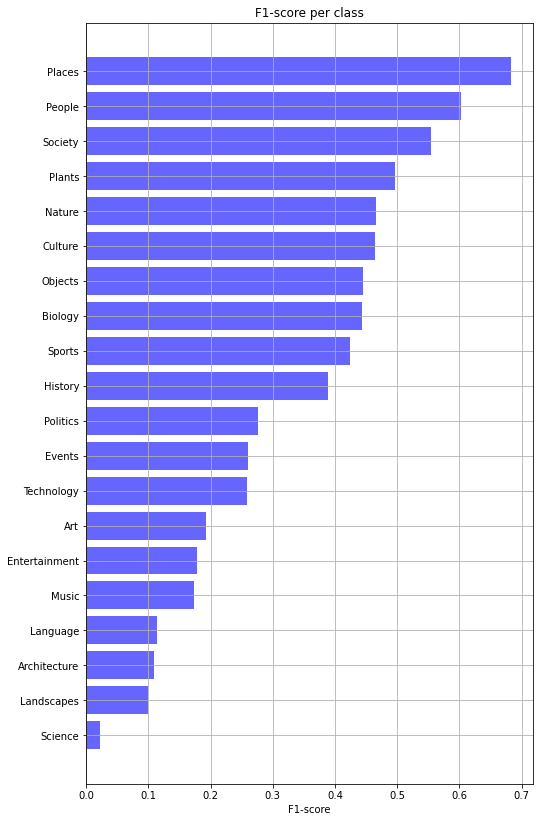

In [13]:
# ================== GET METRICS ======================
from sklearn.metrics import classification_report

def get_metrics(y_true, y_pred):
    print(f'\nMean number of label assignments per image in ground-truth: {np.sum(y_true) / y_true.shape[0]:.4f}')
    print(f'Mean number of label assignments per image in predictions: {np.sum(y_pred) / y_pred.shape[0]:.4f}\n')

    n_labels = y_pred.shape[1]
    metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(test.class_indices), output_dict=True)).transpose()
    metrics_df['index'] = np.concatenate((np.arange(start=0, stop=n_labels), [None, None, None, None]))
    print(metrics_df)

    # F1-scores
    sorted_indices_f1score = np.argsort(metrics_df['f1-score'][0:n_labels])
    sorted_f1score_per_class = metrics_df['f1-score'][0:n_labels][sorted_indices_f1score]

    print(f'\nUnweighted avg. F1-score of all classes: {np.sum(sorted_f1score_per_class) / len(sorted_f1score_per_class)}')
    print(f'Unweighted avg. F1-score of top 5 classes: {np.sum(sorted_f1score_per_class[-4:]) / 5}')
    print(f'Unweighted avg. F1-score of the rest: {np.sum(sorted_f1score_per_class[0:-4]) / (len(sorted_f1score_per_class) - 5)}\n')

    _ = plt.figure(figsize=(8, 14))
                    
    _ = plt.title('F1-score per class')
    _ = plt.barh(range(y_true.shape[1]), sorted_f1score_per_class, color='blue', alpha=0.6)
    _ = plt.yticks(ticks=range(n_labels), labels=np.array(list(test.class_indices.keys()))[sorted_indices_f1score])
    _ = plt.xlabel('F1-score')
    _ = plt.grid(True)

    plt.savefig(config['results_and_checkpoints_folder'] + '/f1_scores.png')

get_metrics(y_true_test, y_pred_test_05)
get_metrics(y_true_test, y_pred_test_per_class_threshold)


#### ROC curve for each class

On micro and macro averaging: Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

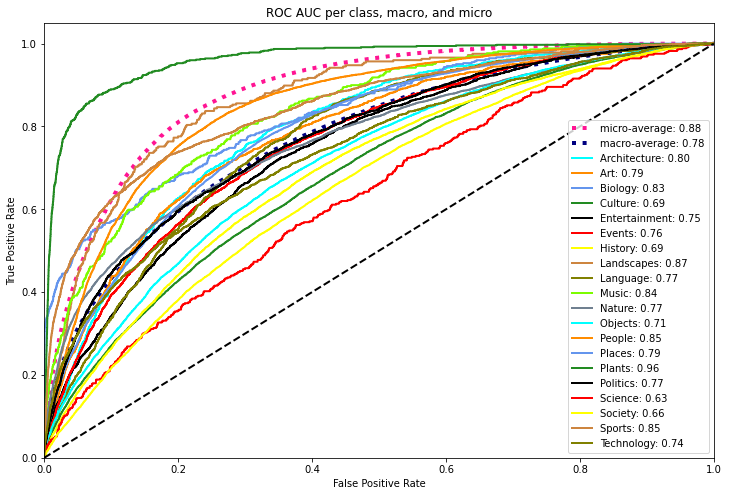

In [17]:
# ================== ROC CURVE PER CLASS ===============
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_LABELS):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
lw = 2
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_LABELS)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(N_LABELS):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= N_LABELS

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves

plt.figure(figsize=(12, 8))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average: { roc_auc['micro'] :0.2f}",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average: { roc_auc['macro'] :0.2f}",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "forestgreen", "black", "red", "yellow", "peru", "olive", "lawngreen", "slategray"])
for i, color in zip(range(N_LABELS), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label=f"{list(name_id_map.keys())[i]}: {roc_auc[i]:0.2f}"
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC per class, macro, and micro")
plt.legend(loc="lower right")
plt.savefig(config['results_and_checkpoints_folder'] + '/roc_curves.png')
# ======================================================

In [18]:
sys.stdout = old_stdout

log_file.close()